In [5]:
## Import packages and functions needed to plot and access the NOMAD Data

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import glob
import csv
import re
from matplotlib.backends.backend_pdf import PdfPages
import tkinter as tk
from tkinter import filedialog, messagebox, simpledialog
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from api_calls_get_data import get_specific_data_of_sample, get_entryid, get_quantity_over_jv


In [2]:
def get_filenames(path):
    sample_ids = set()  # Use a set to store IDs
    
    pattern = r"(.*)\.px\d+\.jv\.csv"
    
    # Go through all files in the directory
    for file in glob.iglob(os.path.join(path, "*.jv*")):    
        # Extract ID from filename
        filename = os.path.basename(file)
        match = re.match(pattern, filename)
        if match:
            sample_ids.add(match.group(1))  # Add to set, duplicates are ignored
                
    return sample_ids

In [8]:

def get_batch_data(sample_ids):
    #Get the NOMAD ID
    samples_of_batch = [(sample_id, get_entryid(sample_id)) for sample_id in sample_ids]

    #Process in which the quantity was changed
    #TODO Make this a variable input as dropdown menu
    key = ["peroTF_CR_SpinBox_SpinCoating"]
    
    #Varied quantities to extract 
    #TODO Make this a variable input as dropdown menu - or from excel file
    quantities=["name"]
    
    #Standard JV parameters to get
    jv_quantities=["efficiency",\
                   "fill_factor",\
                   "open_circuit_voltage",\
                   "short_circuit_current_density"]
    
    #Get data
    df = get_quantity_over_jv(samples_of_batch, key, quantities, jv_quantities)
    
    #Extract Information from ID
    df['last_digit'] = df['sample_id'].str.extract('(\d)$').astype(int)[0]
    df['category'] = df['sample_id'].str.split('_').str[4]
    df['batch_name'] = df['sample_id'].str.split('_').str[3]
    df['batch_date'] = df['sample_id'].str.split('_').str[2]

    # Data cleaning remove shunted or somehow damaged devices using filters
    df = df[df['fill_factor'] >= 0.5]
    df = df[df['open_circuit_voltage'] >= 1]
    df = df[df['short_circuit_current_density'] <= 30]
    df = df[df["fill_factor"] <= 1]


    return df, quantities

In [29]:
def calculate_statistics(df, quantities):    

    result_df = pd.DataFrame(columns=['category',
                                      'standard_deviation',
                                      'median',
                                      'closest_median',
                                      'closest_median_id',
                                      'maximum_efficiency',
                                      'maximum_efficiency_id'])

    for index, category in enumerate(sorted(df['variation'].unique())):
        # Calculate standard deviation
        std_dev = df[df['variation'] == category]['efficiency'].std()
        # Median and closest value to median
        med_eff = df[df['variation'] == category]['efficiency'].median()
        closest_med_eff_value = sorted(df[df['variation'] == category]['efficiency'],
                                       key=lambda x: abs(x - med_eff - 0.000000001))[:1]
        med_id = df[df['efficiency'] == closest_med_eff_value[0]]['sample_id'].values[0]
        # Maximum efficiency value
        max_eff = df[df['variation'] == category]['efficiency'].max()
        max_id = df[df['efficiency'] == max_eff]['sample_id'].values[0]

        # Create a temporary DataFrame with the current results
        temp_df = pd.DataFrame({
            'category': [category],
            'standard_deviation': [np.round(std_dev,2)],
            'median': [np.round(med_eff)],
            'closest_median': [closest_med_eff_value[0]],
            'closest_median_id': [med_id],
            'maximum_efficiency': [max_eff],
            'maximum_efficiency_id': [max_id]
            })

        # Concatenate the temporary DataFrame with the result DataFrame
        result_df = pd.concat([result_df, temp_df], ignore_index=True)

    # Perform ANOVA test
    f_statistic, p_value = f_oneway(*[group['efficiency'] for name, group in df.groupby(quantities[0])])

    if p_value < 0.05:
        # Perform Tukey HSD test
        tukey_results = pairwise_tukeyhsd(df['efficiency'], df['variation'], alpha=0.05)
        print(tukey_results)
    else:
        print("No significant differences between group means.")
            
    return result_df



In [20]:

def plot_JV_curves(result_df, curve_type):
    fig, ax = plt.subplots()
    
    # Define a color palette for the groups
    colors = plt.cm.viridis(np.linspace(0, 1, len(result_df)))
    
    # Set the color cycle for the axes
    ax.set_prop_cycle(color=colors)
    
    for index, row in result_df.iterrows():
        jv_data = get_specific_data_of_sample(row[f'{curve_type}_id'], "JVmeasurement")
        for cell in jv_data:
            for i in range(2):
                if cell["jv_curve"][i]["efficiency"] == row[f'{curve_type}'] and \
                   (curve_type == 'maximum_efficiency' or curve_type == 'closest_median'):
                        ax.plot(cell["jv_curve"][i]["voltage"], \
                                 cell["jv_curve"][i]["current_density"], \
                                 label=f"{row['category']}")
                        print(cell["name"])
                        break

    # Plot settings
    ax.legend()
    ax.set_xlim(-0.2, 1.3)
    ax.set_ylim(-5, 25)
    ax.set_title(f'{curve_type.capitalize()} JV Curves', fontsize=16)
    ax.set_xlabel('Voltage (V)', fontsize=12)
    ax.set_ylabel('Current Density(mA/cm²)', fontsize=12)

    # Axis ticks and borders
    ax.tick_params(axis='both', which='both', direction='in', width=2, bottom=1, top=1, left=1, right=1)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    # Zero lines
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.axvline(x=0, color='black', linewidth=0.5)
    
    #fig.savefig(f"{curve_type}.png", dpi=300, transparent=True, bbox_inches='tight')

    return fig

In [30]:
def plot_box_and_scatter(df, quantities, jv_quantity):
    # Define a color palette for the groups
    colors = plt.cm.viridis(np.linspace(0, 1, len(df['variation'].unique())))
    
    # Define Y-Axis Labels
    quantity_labels = {
        'open_circuit_voltage': 'Open Circuit Voltage (V)',
        'fill_factor': 'Fill Factor (%)',
        'efficiency': 'Efficiency (%)',
        'short_circuit_current_density': 'Short Circuit Current Density (mA/cm²)'
    }

    fig, ax = plt.subplots(figsize=(10, 5))

    positions = [i + 1 for i in range(len(df['variation'].unique()))]  # Define positions for each group

    # Draw the box plot without fliers and with colors
    boxprops = dict(facecolor='white', color='black')
    medianprops = dict(color='red')
    for i, (group, color) in enumerate(zip(sorted(df['variation'].unique()), colors)):
        group_data = df[df['variation'] == group][jv_quantity]
        box = ax.boxplot(group_data, positions=[positions[i]], showmeans=False, showfliers=False, widths=0.5, patch_artist=True,
                          boxprops=dict(facecolor=color, color='black'),
                          medianprops=medianprops)

    # Overlay the scatter plot with black points
    for i, group in enumerate(sorted(df['variation'].unique())):
        group_data = df[df['variation'] == group]
        # Add jitter to x positions
        jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(group_data))
        ax.scatter(jittered_x, group_data[jv_quantity], color='black', alpha=1, zorder=3)

    # Axis label and Ticks
    ax.set_ylabel(f"{quantity_labels[jv_quantity]}", size=16)
    ax.set_xticks(positions)
    ax.set_xticklabels(df['variation'].unique(), size=14)
    ax.set_yticks(ax.get_yticks())
    ax.tick_params(axis='both', labelsize=14)

    # Border line and Ticks Formatting
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.tick_params(axis='both', right=True, top=True, direction='in', width=2, colors='black', length=5)

    # Transparent Background
    fig.patch.set_facecolor('none')
    ax.patch.set_facecolor('none')

    # Save the figure
    #fig.savefig(f"{jv_quantity}.png", dpi=300, transparent=True, bbox_inches='tight')

    return fig


In [22]:
def plot_EQE_curves(result_df):
    
    fig, ax = plt.subplots()
    
    # Define a color palette for the groups
    colors = plt.cm.viridis(np.linspace(0, 1, len(result_df)))
    
    # Set the color cycle for the axes
    ax.set_prop_cycle(color=colors)
    
    for index, row in result_df.iterrows():
        #Data from server
        eqe_data = get_specific_data_of_sample(row[f'maximum_efficiency_id'],'EQEmeasurement')
        #Relevant arrays
        wavelength_array = eqe_data[0]['eqe_data'][0]['wavelength_array']
        eqe_array = eqe_data[0]['eqe_data'][0]['eqe_array']
        #Plot
        ax.plot(wavelength_array, eqe_array, label=f"{row['category']}", color=colors[index])
        print(row[f'maximum_efficiency_id'])
                        

    # Plot settings
    ax.legend()
    ax.set_xlim(300, 900)
    ax.set_ylim(0, 1)
    ax.set_title(f'EQE Curves', fontsize=16)
    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    ax.set_ylabel('EQE (%)', fontsize=12)

    # Axis ticks and borders
    ax.tick_params(axis='both', which='both', direction='in', width=2, bottom=1, top=1, left=1, right=1)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    # Zero lines
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.axvline(x=0, color='black', linewidth=0.5)
    
    #fig.savefig(f"{curve_type}.png", dpi=300, transparent=True, bbox_inches='tight')

    return fig

In [23]:
def plot_MPP_curves(result_df):
    
    fig, ax = plt.subplots()
    
    # Define a color palette for the groups
    colors = plt.cm.viridis(np.linspace(0, 1, len(result_df)))
    
    # Set the color cycle for the axes
    ax.set_prop_cycle(color=colors)
    
    for index, row in result_df.iterrows():
        #Data from server
        mpp_data = get_specific_data_of_sample(row[f'maximum_efficiency_id'],'MPPTracking')
        #Relevant arrays
        time_array = mpp_data[0]['time']
        pce_array = mpp_data[0]['efficiency']
        voltage_array = mpp_data[0]['voltage']
        last_pce = mpp_data[0]['properties']['last_pce']
        #Plot
        ax.plot(time_array, pce_array, label=f"{row['category']}", color=colors[index])
        print(row[f'maximum_efficiency_id'])
                        

    # Plot settings
    ax.legend()
    ax.set_xlim(0, 300)
    ax.set_ylim(0, 25)
    ax.set_title(f'MPP Tracking', fontsize=16)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('PCE (%)', fontsize=12)

    # Axis ticks and borders
    ax.tick_params(axis='both', which='both', direction='in', width=2, bottom=1, top=1, left=1, right=1)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    # Zero lines
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.axvline(x=0, color='black', linewidth=0.5)
    
    #fig.savefig(f"{curve_type}.png", dpi=300, transparent=True, bbox_inches='tight')

    return fig

In [33]:
def generate_pdf_report(result_df, df, quantities, report_title):
    with PdfPages(report_title) as pdf:
        # Plot the maximum JV curves
        fig_max = plot_JV_curves(result_df, 'maximum_efficiency')
        pdf.savefig(fig_max, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_max)

        # Plot the median JV curves
        fig_med = plot_JV_curves(result_df, 'closest_median')
        pdf.savefig(fig_med, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_med)

        # Add any other plots or content to the PDF here
        fig_eff = plot_box_and_scatter(df, df['variation'], 'efficiency')
        pdf.savefig(fig_eff, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_eff)
        
        fig_ff = plot_box_and_scatter(df, df['variation'], 'fill_factor')
        pdf.savefig(fig_ff, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_ff)
        
        fig_voc = plot_box_and_scatter(df, df['variation'], 'open_circuit_voltage')
        pdf.savefig(fig_voc, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_voc)
        
        fig_jsc = plot_box_and_scatter(df, df['variation'], 'short_circuit_current_density')
        pdf.savefig(fig_jsc, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_jsc)
        
        # Add result_df as a table to the PDF
        fig_table, ax_table = plt.subplots(figsize=(10, 5))
        ax_table.axis('off')  # Hide axis
        table = ax_table.table(result_df, colLabels=result_df.columns, loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        pdf.savefig(fig_table, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_table)

    print("PDF report generated successfully.")

In [3]:
path = "//129.13.79.200/AG_Lemmer$/Forschungsprojekte/Spektroskopie/Perovskite solar cells/Data/SonSim/Maria (Daniel)/"

In [12]:
def main():
    root = tk.Tk()
    root.withdraw()
    path = filedialog.askdirectory(title="Select Directory")
    if not path:
        print("No directory selected")
        return

    sample_ids = get_filenames(path)
    df, quantities = get_batch_data(sample_ids)
    result_df = calculate_statistics(df, quantities)
    generate_pdf_report(result_df, df, [quantities[0]])
    
    print("ALL TASKS COMPLETED")




In [36]:
result_df

,category,standard_deviation,median,closest_median,closest_median_id,maximum_efficiency,maximum_efficiency_id
0,Arch,1.72,17.0,16.75947,KIT_MaAy_20241126_Nozzles_1_3,17.89976,KIT_MaAy_20241126_Nozzles_1_3
1,Cone,1.44,16.0,16.41303,KIT_MaAy_20241126_Nozzles_2_5,18.11641,KIT_MaAy_20241126_Nozzles_2_1
2,Ref,1.43,17.0,16.72225,KIT_MaAy_20241126_Nozzles_0_0,18.18467,KIT_MaAy_20241126_Nozzles_0_2
3,Tilted,1.85,17.0,17.11568,KIT_MaAy_20241206_NozzlesTmH_0_1,18.11952,KIT_MaAy_20241206_NozzlesTmH_0_1
4,mHoles,1.60,17.0,17.33712,KIT_MaAy_20241206_NozzlesTmH_1_2,18.16526,KIT_MaAy_20241206_NozzlesTmH_1_1


C:\Users\hr0264\AppData\Local\Temp\ipykernel_19532\3879553525.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, temp_df], ignore_index=True)


No significant differences between group means.
KIT_MaAy_20241126_Nozzles_1_3 px2
KIT_MaAy_20241126_Nozzles_2_1 px2
KIT_MaAy_20241126_Nozzles_0_2 px3
KIT_MaAy_20241206_NozzlesTmH_0_1 px4
KIT_MaAy_20241206_NozzlesTmH_1_1 px3
KIT_MaAy_20241126_Nozzles_1_3 px1
KIT_MaAy_20241126_Nozzles_2_5 px2
KIT_MaAy_20241126_Nozzles_0_0 px4
KIT_MaAy_20241206_NozzlesTmH_0_1 px2
KIT_MaAy_20241206_NozzlesTmH_1_2 px4


KeyError: 0

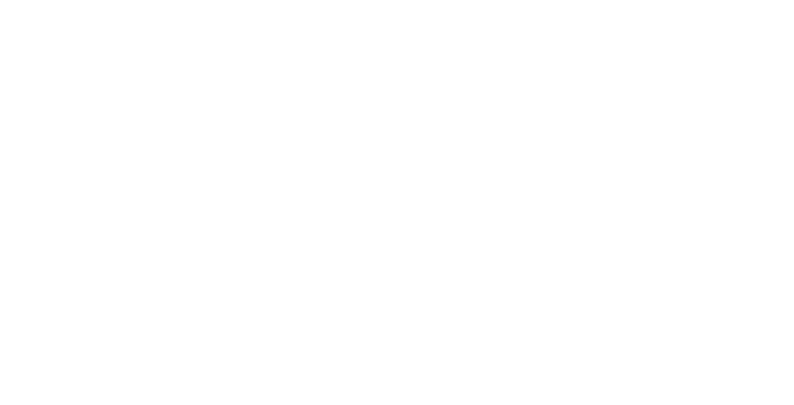

In [35]:
df = df[df['fill_factor'] >= 0.5]
df = df[df['open_circuit_voltage'] >= 1]
df = df[df['short_circuit_current_density'] <= 35]
df = df[df["fill_factor"] <= 1]
quantities = ["variation"]
result_df = calculate_statistics(df, quantities)
generate_pdf_report(result_df, df, quantities, "Nozzle_Report2.pdf")

In [106]:
result_df.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)

,category,standard_deviation,median,closest_median,closest_median_id,maximum_efficiency,maximum_efficiency_id
0,Arch,1.72,17.0,16.76,KIT_MaAy_20241126_Nozzles_1_3,17.90,KIT_MaAy_20241126_Nozzles_1_3
1,Cone,1.44,16.0,16.41,KIT_MaAy_20241126_Nozzles_2_5,18.12,KIT_MaAy_20241126_Nozzles_2_1
2,Ref,1.43,17.0,16.72,KIT_MaAy_20241126_Nozzles_0_0,18.18,KIT_MaAy_20241126_Nozzles_0_2
3,Tilted,1.85,17.0,17.12,KIT_MaAy_20241206_NozzlesTmH_0_1,18.12,KIT_MaAy_20241206_NozzlesTmH_0_1
4,mHoles,1.60,17.0,17.34,KIT_MaAy_20241206_NozzlesTmH_1_2,18.17,KIT_MaAy_20241206_NozzlesTmH_1_1


In [15]:
path

'//129.13.79.200/AG_Lemmer$/Forschungsprojekte/Spektroskopie/Perovskite solar cells/Data/SonSim/Maria (Daniel)/'

In [16]:
from openpyxl import load_workbook

# Load the Excel file
file_path = path + "ExperimentsInfo.xlsx"  # Replace with your file path
workbook = load_workbook(filename=file_path, data_only=True)
sheet = workbook.active  # Access the active worksheet

# Extract data from columns 6 (sample_id) and 7 (group names)
data = []
for row in sheet.iter_rows(min_row=3, min_col=6, max_col=7, values_only=True):
    sample_id, group_name = row
    data.append((sample_id, group_name))

# Convert the extracted data to a DataFrame
excel_df = pd.DataFrame(data, columns=["sample_id", "variation"])


df, quantities = get_batch_data(excel_df["sample_id"].unique())
# Merge with the existing DataFrame on 'sample_id'
# Assume `df` is your existing DataFrame
df = excel_df.merge(df, on="sample_id", how="left")

# Print the updated DataFrame
#print(df)



In [28]:
sorted(df['variation'].unique())

['Arch', 'Cone', 'Ref', 'Tilted', 'mHoles']

In [55]:
samples_of_batch = [(sample_id, get_entryid(sample_id)) for sample_id in sample_ids]
samples_of_batch

[('KIT_DaBa_20241204_Pass_3_3', 'j-vkOmI2QbA6fII7XpRSUGtsnsqP'),
 ('KIT_DaBa_20241204_Pass_4_1', '4LKXAPkMTU07Lr_YOdnSO0VRw50S'),
 ('KIT_DaBa_20241204_Pass_5_3', 'kqUqclyG7VEc34Eoukr14-ckl2SI'),
 ('KIT_DaBa_20241204_Pass_4_2', '_PbW-jWsQPCEJxCE5D1Fe-F2QsIc'),
 ('KIT_DaBa_20241204_Pass_4_3', '-mFkZsaZZ74EpC_sa25BJdlM96me'),
 ('KIT_DaBa_20241204_Pass_0_2', 'bI8gVUm_JikPmgg29Z_YbBLS7ZwS'),
 ('KIT_DaBa_20241204_Pass_1_2', 'rNJHRUcSvOf8iULkBAiNIuMm3szF'),
 ('KIT_DaBa_20241204_Pass_5_2', 'V2hWLELtcpQBIEy9IxLICAGGlsCk'),
 ('KIT_DaBa_20241204_Pass_2_2', 'UQjVFprfiJJXNOjWxaA3n5qLTJL3'),
 ('KIT_DaBa_20241204_Pass_0_1', 'GQkY7o8qFuLlW3CCl6vT3qZCTtzU'),
 ('KIT_DaBa_20241204_Pass_2_0', 'uyCjQu2wL8GTPsTxX3rXQXHzYBQR'),
 ('KIT_DaBa_20241204_Pass_1_3', '5x1V6Kz08diBpWYMPvSuThYscda4'),
 ('KIT_DaBa_20241204_Pass_1_1', 'brrE5lS6YFxovfh399TGNaDK5IsV'),
 ('KIT_DaBa_20241204_Pass_2_3', 'JSLC5KapxW0UHSjP58t1v90vVwfm'),
 ('KIT_DaBa_20241204_Pass_3_2', 'NogOw8KmMLE_es1ekt0KqpRGtbuX'),
 ('KIT_DaBa_20241204_Pass

In [87]:
query = {
        'required': {
            'metadata': '*'
        },
        'owner': 'visible',
        'query': {'results.eln.lab_ids': 'KIT_DaBa_20241204_Pass_0_1'},
        'pagination': {
            'page_size': 100
        }
    }
response = requests.post(
        f'{url}/entries/query', headers={'Authorization': f'Bearer {token}'}, json=query)
data = response.json()["data"]

In [36]:
import requests
url = "http://elnserver.lti.kit.edu/nomad-oasis/api/v1"
response = requests.get(
    f'{url}/auth/token', params=dict(username='d.baumann', password='K!7:Baum96'))
token = response.json()['access_token']


In [88]:
data[0]["entry_id"]

'GQkY7o8qFuLlW3CCl6vT3qZCTtzU'